# Logistic classifier

Given EDA we will train a simple logistic model trying to predict which team is most likely to win.

> Note that this notebook is actively utilizing `numpy` over `pandas`.

In [1]:
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss, f1_score, accuracy_score, confusion_matrix, PrecisionRecallDisplay

import matplotlib.pyplot as plt
import seaborn as sns

from constants import FILENAME, TARGET, TARG_FEAT, DATE_FEATURE_CIDX, HIGH_CAR, LOW_CAR, CIDX, CNAMES, MOD_FEAT
from utils.data_utils import read_csv2, data_split

sns.set()

## Load data

In [2]:
# Load data directly as numpy array
data, _ = read_csv2(f'data/{FILENAME}')

## Modeling features and preprocessing

In [3]:
# Modeling features column index
mod_feat_cidx = [i for i in CIDX if CNAMES[i] in MOD_FEAT]

# Feature mapping
mod_feat_map = np.c_[np.arange(len(MOD_FEAT)), mod_feat_cidx]
print(mod_feat_map)

[[ 0  4]
 [ 1  6]
 [ 2  7]
 [ 3  8]
 [ 4  9]
 [ 5 26]
 [ 6 27]
 [ 7 28]
 [ 8 29]
 [ 9 30]
 [10 51]
 [11 52]
 [12 53]
 [13 54]
 [14 55]]


In [4]:
# Map modeling features to high or low cardinality
low_car_cidx = list(set(mod_feat_map[:, 1]).intersection(set([i for i in CIDX if CNAMES[i] in LOW_CAR])))
print(f'Low cardinality feature cidx: {low_car_cidx}')

high_car_cidx = list(set(mod_feat_map[:, 1]).intersection(set([i for i in CIDX if CNAMES[i] in HIGH_CAR])))
print(f'High cardinality feature cidx: {high_car_cidx}')

Low cardinality feature cidx: [6, 7, 8, 9, 51, 52, 53, 54, 55, 26, 27, 28, 29, 30]
High cardinality feature cidx: []


In [5]:
low_car = [mod_feat_map[mod_feat_map[:, 1] == i, 0][0] for i in low_car_cidx]
high_car = [mod_feat_map[mod_feat_map[:, 1] == i, 0][0] for i in high_car_cidx]

In [6]:
# Sort lists
low_car.sort()
high_car.sort()

# Reduce index by 1 since target feature will not be present in modeling set
low_car = [i - 1 for i in low_car]
high_car = [i - 1 for i in high_car]

print(f'Low cardinaly column indices in modeling data: {low_car}')
print(f'High cardinaly column indices in modeling data: {high_car}')

Low cardinaly column indices in modeling data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
High cardinaly column indices in modeling data: []


In [7]:
# Numerical preprocessor
num_pp = make_pipeline(
    SimpleImputer(strategy='median'),
    KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='ordinal')
)

# Categorical preprocessor
cat_pp = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [8]:
# Column transformer
if low_car and high_car:
    preprocessor = make_column_transformer(
        (num_pp, high_car),
        (cat_pp, low_car)
    )
elif low_car and not high_car:
    preprocessor = make_column_transformer(
        (cat_pp, low_car)
    )
elif high_car and not low_car:
    preprocessor = make_column_transformer(
        (num_pp, high_car)
    )

## Data split

In [9]:
# Split data into train, val, and test sets
data_train, data_val, data_test = data_split(data, DATE_FEATURE_CIDX)

In [10]:
# Shapes of splits
print(f'Train shape: {data_train.shape}')
print(f'Validation shape: {data_val.shape}')
print(f'Test shape: {data_test.shape}')

Train shape: (40842, 61)
Validation shape: (5105, 61)
Test shape: (5106, 61)


In [11]:
# Extract modeling columns
X_train, y_train = data_train[:, mod_feat_cidx[1:]], data_train[:, mod_feat_cidx[0]]
X_val, y_val = data_val[:, mod_feat_cidx[1:]], data_val[:, mod_feat_cidx[0]]
X_test, y_test = data_test[:, mod_feat_cidx[1:]], data_test[:, mod_feat_cidx[0]]

# Modify target to 0, 1
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

# Check shape of data
print(f'Shape of training features data: {X_train.shape}')
print(f'Shape of training label data: {y_train.shape}')
print(f'Shape of validation features data: {X_val.shape}')
print(f'Shape of validation label data: {y_val.shape}')
print(f'Shape of test features data: {X_test.shape}')
print(f'Shape of test label data: {y_test.shape}')

Shape of training features data: (40842, 14)
Shape of training label data: (40842,)
Shape of validation features data: (5105, 14)
Shape of validation label data: (5105,)
Shape of test features data: (5106, 14)
Shape of test label data: (5106,)


## Train logistic model

In [12]:
# Model pipeline
model = make_pipeline(
    preprocessor,
    LogisticRegressionCV(max_iter=2000)
)

# Fit model using pipeline
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13])])),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=2000))])

## Model performance

In [13]:
# Prediction on validation data
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]

print(y_pred_val.shape)
print(y_val.shape)

(5105,)
(5105,)


In [14]:
print(f'Accuracy: {accuracy_score(y_val, y_pred_val)}')
print(f'Logloss: {log_loss(y_val, y_pred_proba_val)}')
print(f'F1 score: {f1_score(y_val, y_pred_val)}')

Accuracy: 0.9682664054848188
Logloss: 0.0709668193276005
F1 score: 0.9681728880157171


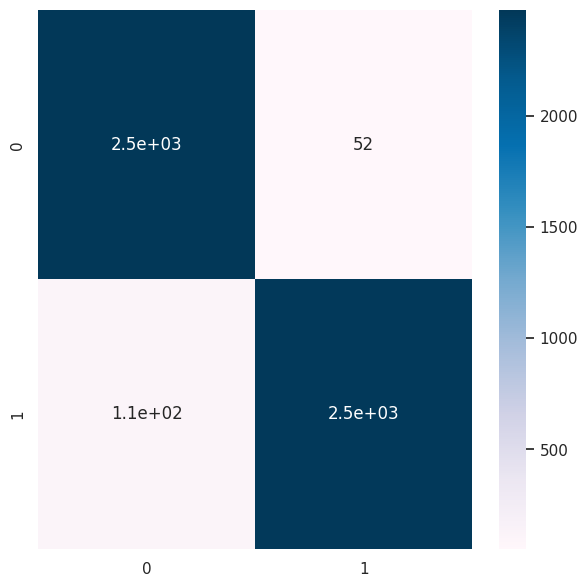

In [15]:
# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(7,7))
sns.heatmap(cm_val, annot=True, cmap=plt.cm.PuBu)
plt.show()

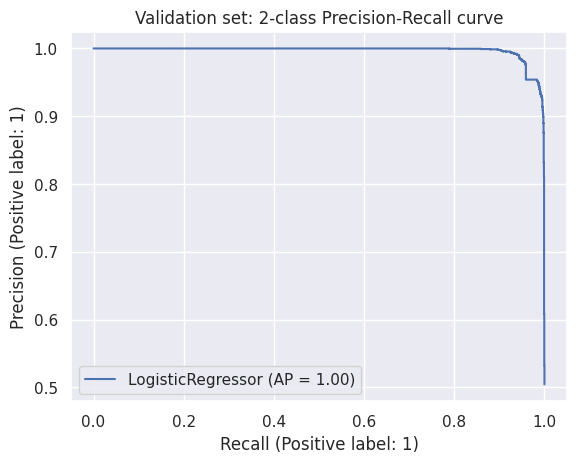

In [16]:
# Precision-Recall curve
display = PrecisionRecallDisplay.from_estimator(
    model, X_val, y_val, name="LogisticRegressor"
)
_ = display.ax_.set_title("Validation set: 2-class Precision-Recall curve")

## Performance on test data

In [17]:
# Prediction on validation data
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

print(y_pred_test.shape)
print(y_test.shape)

(5106,)
(5106,)


In [18]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'Logloss: {log_loss(y_test, y_pred_proba_test)}')
print(f'F1 score: {f1_score(y_test, y_pred_test)}')

Accuracy: 0.9737563650607128
Logloss: 0.05742235549010182
F1 score: 0.9736116581331232


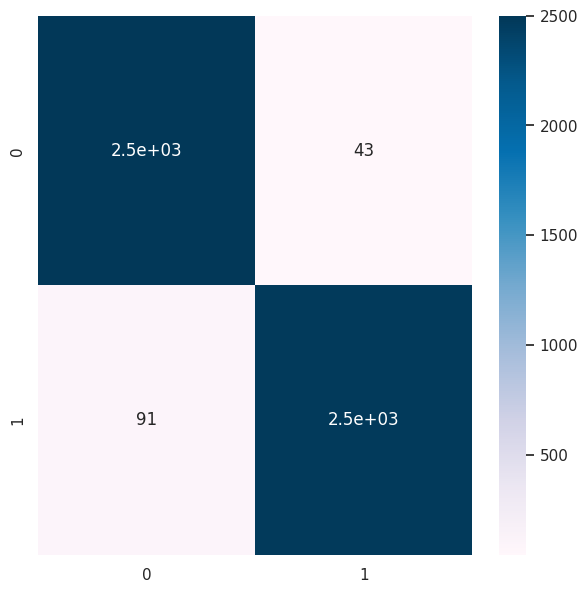

In [19]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(7,7))
sns.heatmap(cm_test, annot=True, cmap=plt.cm.PuBu)
plt.show()

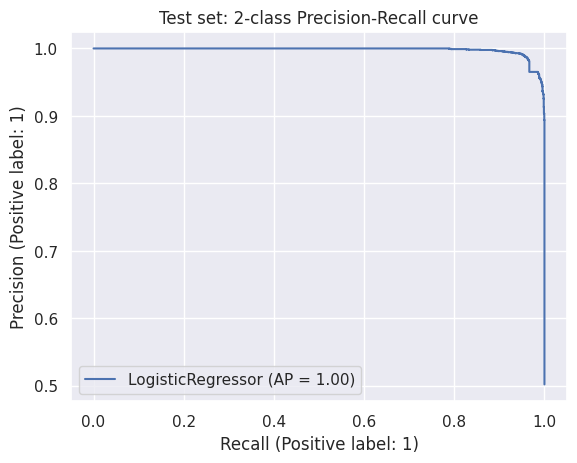

In [20]:
# Precision-Recall curve
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="LogisticRegressor"
)
_ = display.ax_.set_title("Test set: 2-class Precision-Recall curve")